<a href="https://colab.research.google.com/github/cjfergie/Reinforcement-Learning/blob/main/Q_Learning_Trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/sp500_closefull.csv

--2024-04-01 00:32:15--  https://lazyprogrammer.me/course_files/sp500_closefull.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18464866 (18M) [text/csv]
Saving to: ‘sp500_closefull.csv’

sp500_closefull.csv 100%[===================>]  17.61M  75.5MB/s    in 0.2s    

2024-04-01 00:32:15 (75.5 MB/s) - ‘sp500_closefull.csv’ saved [18464866/18464866]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [3]:
df0 = pd.read_csv('sp500_closefull.csv', index_col=0, parse_dates=True)
df0.dropna(axis=0, how = 'all', inplace=True)
df0.dropna(axis=1, how = 'all', inplace=True)

In [4]:
data = {}
for name in df0.columns:
  data[name] = np.log(df0[name]).diff()
df_returns = pd.DataFrame(data=data)

In [5]:
# split into train and test
Ntest = 1000
train_data = df_returns.iloc[:-Ntest]
test_data = df_returns.iloc[-Ntest:]

In [6]:
feats = ['AAPL', 'MSFT', 'AMZN']

In [19]:
class Env:
  def __init__(self, df):
    self.df = df
    self.n = len(df)
    self.current_idx = 0
    self.action_space = [0, 1, 2] # BUY, SELL, HOLD
    self.invested = 0

    self.states = self.df[feats].to_numpy()
    self.rewards = self.df['SPY'].to_numpy()

  def reset(self):
    self.current_idx = 0
    return self.states[self.current_idx]

  def step(self, action):
    # need to return (next_state, reward, done)

    self.current_idx += 1
    if self.current_idx >= self.n:
      raise Exception("Episode already done")

    if action == 0: # BUY
      self.invested = 1
    elif action == 1: # SELL
      self.invested = 0

    # compute reward
    if self.invested:
      reward = self.rewards[self.current_idx]
    else:
      reward = 0

    # state transition
    next_state = self.states[self.current_idx]

    done = (self.current_idx == self.n - 1)
    return next_state, reward, done

In [24]:
class StateMapper:
  def __init__(self, env, n_bins=6, n_samples=10000):
    # first, collect sample states from the environment
    states = []
    done = False
    s = env.reset()
    self.D = len(s) # number of elements we need to bin
    states.append(s)
    while True:
      a = np.random.choice(env.action_space)
      s2, _, done = env.step(a)
      states.append(s2)
      if len(states) >= n_samples:
        break
      if done:
        s = env.reset()
        states.append(s)
        if len(states) >= n_samples:
          break

    # convert to numpy array for easy indexing
    states = np.array(states)

    # create the bins for each dimension
    self.bins = []
    for d in range(self.D):
      column = np.sort(states[:,d])

      # find the boundaries for each bin
      current_bin = []
      for k in range(n_bins):
        boundary = column[int(n_samples / n_bins * (k + 0.5))]
        current_bin.append(boundary)

      self.bins.append(current_bin)


  def transform(self, state):
    x = np.zeros(self.D)
    for d in range(self.D):
      x[d] = int(np.digitize(state[d], self.bins[d]))
    return tuple(x)


  def all_possible_states(self):
    list_of_bins = []
    for d in range(self.D):
      list_of_bins.append(list(range(len(self.bins[d]) + 1)))
    # print(list_of_bins)
    return itertools.product(*list_of_bins)

In [26]:
class Agent:
  def __init__(self, action_size, state_mapper):
    self.action_size = action_size
    self.gamma = 0.8  # discount rate
    self.epsilon = 0.1
    self.learning_rate = 1e-1
    self.state_mapper = state_mapper

    # initialize Q-table randomly
    self.Q = {}
    for s in self.state_mapper.all_possible_states():
      s = tuple(s)
      for a in range(self.action_size):
        self.Q[(s,a)] = np.random.randn()

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)

    s = self.state_mapper.transform(state)
    act_values = [self.Q[(s,a)] for a in range(self.action_size)]
    return np.argmax(act_values)  # returns action

  def train(self, state, action, reward, next_state, done):
    s = self.state_mapper.transform(state)
    s2 = self.state_mapper.transform(next_state)

    if done:
      target = reward
    else:
      act_values = [self.Q[(s2,a)] for a in range(self.action_size)]
      target = reward + self.gamma * np.amax(act_values)

    # Run one training step
    self.Q[(s,action)] += self.learning_rate * (target - self.Q[(s,action)])

In [27]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    total_reward += reward
    if is_train:
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return total_reward

In [28]:
num_episodes = 500

In [29]:
train_env = Env(train_data)
test_env = Env(test_data)

In [30]:
action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size, state_mapper)

In [31]:
train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

In [32]:
for e in range(num_episodes):
  r = play_one_episode(agent, train_env, is_train=True)
  train_rewards[e] = r

  # test on the test set
  tmp_epsilon = agent.epsilon
  agent.epsilon = 0
  tr = play_one_episode(agent, test_env, is_train=False)
  agent.epsilon = tmp_epsilon
  test_rewards[e] = r

  print(f"eps: {e + 1}/{num_episodes}, train: {r:.5f}, test: {tr:.5f}")

eps: 1/500, train: 0.22800, test: 0.08198
eps: 2/500, train: 0.24596, test: 0.11376
eps: 3/500, train: 0.18140, test: 0.12310
eps: 4/500, train: 0.53366, test: 0.10554
eps: 5/500, train: 0.38069, test: 0.13729
eps: 6/500, train: 0.45098, test: 0.08622
eps: 7/500, train: 0.38914, test: 0.10658
eps: 8/500, train: 0.33526, test: 0.13525
eps: 9/500, train: 0.49398, test: 0.07344
eps: 10/500, train: 0.23148, test: 0.10941
eps: 11/500, train: 0.63264, test: 0.08630
eps: 12/500, train: 0.46895, test: 0.00759
eps: 13/500, train: 0.50235, test: -0.05103
eps: 14/500, train: 0.31282, test: 0.02081
eps: 15/500, train: 0.39912, test: 0.03190
eps: 16/500, train: 0.13799, test: -0.12766
eps: 17/500, train: 0.20195, test: -0.09817
eps: 18/500, train: 0.30879, test: 0.05847
eps: 19/500, train: 0.30393, test: -0.14512
eps: 20/500, train: 0.19159, test: -0.12758
eps: 21/500, train: 0.31041, test: -0.03073
eps: 22/500, train: 0.21813, test: 0.02687
eps: 23/500, train: 0.30913, test: 0.00096
eps: 24/500, t

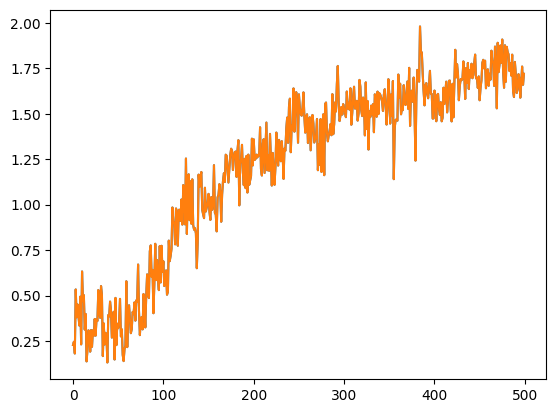

In [36]:
plt.plot(train_rewards);
plt.plot(test_rewards);